In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [4]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Utilities import Tools
from mppi.Datasets import PostProcessing as PP
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [79]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task = 2
omp_num_threads = 2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 32 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PhoGra',qos='m100_qos_bprod',
                memory='230GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr) #,reformat=False
code.global_options()

# GW convergence analysis for monolayer MoS$_2$

We perform a convergence study for the GW runlevel

In particular we make usage of the _slab z_ option to implement the cutoff of the Coulomb and effective potentials in the $z$ direction.

We use this runlevel to study the convergence of some computational parameters that is relevant
also for the BSE analysis.

## HF Analysis for RIM and Coulomb cutoff parameters

As a first step we use this runlevel to study the convergence properties of the RIM and Coulomb cutoff procedures.

This analysis is performed with a 18x18x1 k-points sampling.

In [6]:
source_dir = 'DFT_analysis/kpoints_18-nbnds_250.save'
run_dir = 'GW_analysis/kpoints_18-nbnds_250'

Tools.build_SAVE(source_dir,run_dir)

SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.


We compute the HF gap at the $\Gamma$ and $K$ point and use these values to study the convergence
of the RIM and cutoff procedures.

Here we define the parameters common to all the runs.

In [7]:
start_band,stop_band = 26,27 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 37

EXXRLvcs = 40. # Ha # reference value, the convergence of this parameter will be performed later
EXXRLVcs_units = 'Ha'

In [8]:
inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
inp.set_extendOut()
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]

inp.set_bandRange(start_band,stop_band)
inp['variables']['CUTGeo'] = 'slab z'

inp

{'args': 'mpirun -np 1 yambo -r -x -V all',
 'folder': 'GW_analysis/kpoints_18-nbnds_250',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC', 'ExtendOut'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [26.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [262858.0, 'Kb'],
  'FFTGvecs': [18201.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [0.0, ''],
  'RandGvec': [1.0, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [40.0, 'Ha'],
  'VXCRLvcs': [40.0, 'Ha'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 37, 26, 27], ''],
  'QPerange': [[1, 37, 0.0, '-1.000000'], '']}}

We perform a convergence run on the RandGvec parameter

In [12]:
# test to see of yambo accepts the RIM_W runlevel
inp.write(run_dir,'test.in',reformat=True)

In [9]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

RandQpts = 1000000 # Number of random q-points in the BZ
RandGvec = [15,30,50,100,150,200] # use the RIM for the first RandGvec G-components of the coulomb potential 
RandGvecW = 9

inp['variables']['RandQpts'] = [RandQpts,'']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']

# append runs for the Gamma point
for randgvec in RandGvec:
    idd = 'hf-G-randqpts_%s-randgvec_%s-randgvecw_%s'%(RandQpts,randgvec,RandGvecW)
    inp.set_kRange(Gamma_index,Gamma_index)
    inp['variables']['RandGvec'] = [randgvec,'RL']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for randgvec in RandGvec:
    idd = 'hf-K-randqpts_%s-randgvec_%s-randgvecw_%s'%(RandQpts,randgvec,RandGvecW)
    inp.set_kRange(K_index,K_index)
    inp['variables']['RandGvec'] = [randgvec,'RL']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 4 parallel tasks


In [10]:
#study.runs[0]

In [11]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]] 

Run the task [0, 1, 2, 3] 
Skip the run of Skip the run ofhf-G-randqpts_1000000-randgvec_15-randgvecw_9
 Skip the run ofhf-G-randqpts_1000000-randgvec_30-randgvecw_9 
hf-G-randqpts_1000000-randgvec_50-randgvecw_9
Skip the run of hf-G-randqpts_1000000-randgvec_100-randgvecw_9
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of hf-G-randqpts_1000000-randgvec_150-randgvecw_9Skip the run of
 Skip the run ofhf-G-randqpts_1000000-randgvec_200-randgvecw_9
 Skip the run ofhf-K-randqpts_1000000-randgvec_15-randgvecw_9 
hf-K-randqpts_1000000-randgvec_30-randgvecw_9
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9, 10, 11] 
Skip the run of hf-K-randqpts_1000000-randgvec_50-randgvecw_9Skip the run of
 hf-K-randqpts_1000000-randgvec_100-randgvecw_9
Skip the run of hf-K-randqpts_1000000-randgvec_200-randgvecw_9
Skip the run of hf-K-randqpts_1000000-rand

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [12]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([8.561769, 8.561123, 8.560836, 8.560893, 8.561097, 8.560928],
 [6.363658, 6.363419, 6.363363, 6.363249, 6.363053000000001, 6.363111])

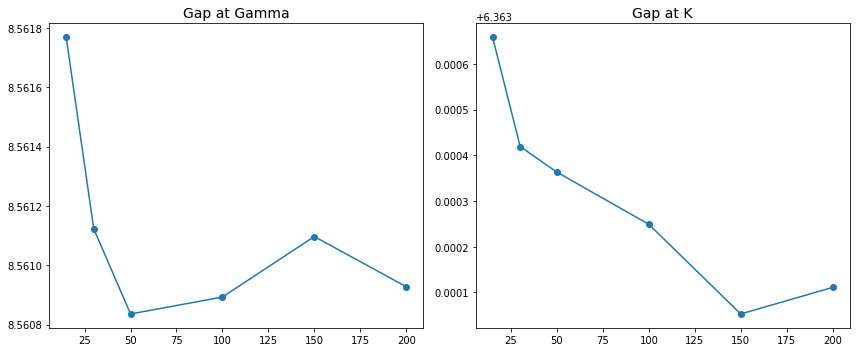

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandGvec,gap_G)
axes[0].scatter(RandGvec,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(RandGvec, gap_K)
axes[1].scatter(RandGvec,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We also show the values of the valence and conduction bands

In [14]:
val_G = [r.data['hf']['Ehf'][0] for r in results_G]
cond_G = [r.data['hf']['Ehf'][1] for r in results_G]

val_K = [r.data['hf']['Ehf'][0] for r in results_K]
cond_K = [r.data['hf']['Ehf'][1] for r in results_K]

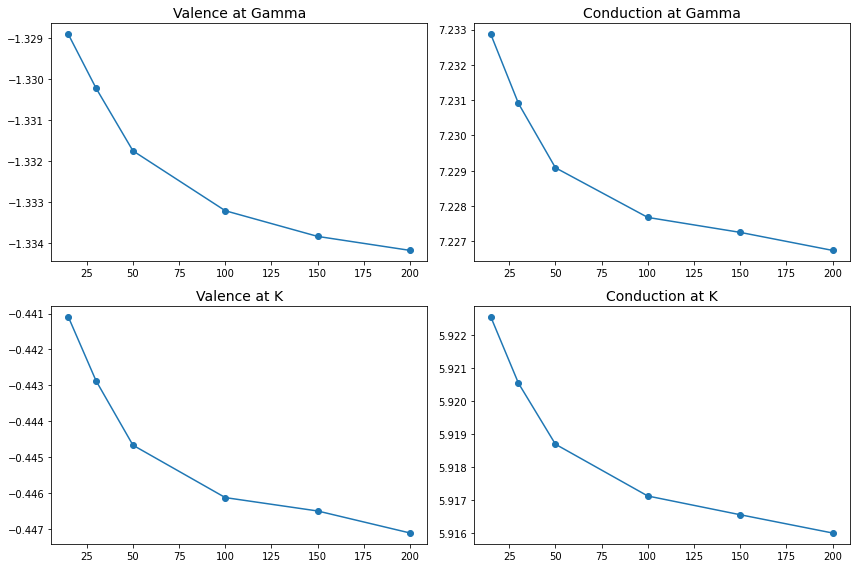

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0,0].plot(RandGvec,val_G)
axes[0,0].scatter(RandGvec,val_G)
axes[0,0].set_title('Valence at Gamma',size=14)
axes[0,1].plot(RandGvec, cond_G)
axes[0,1].scatter(RandGvec,cond_G)
axes[0,1].set_title('Conduction at Gamma',size=14)

axes[1,0].plot(RandGvec,val_K)
axes[1,0].scatter(RandGvec,val_K)
axes[1,0].set_title('Valence at K',size=14)
axes[1,1].plot(RandGvec, cond_K)
axes[1,1].scatter(RandGvec,cond_K)
axes[1,1].set_title('Conduction at K',size=14)

fig.tight_layout()

The states converge much slower than the associated gaps.

We perform a convergence run on the RandQpts parameter

In [16]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

RandQpts = [1000000,2000000,3000000,5000000,8000000] # Number of random q-points in the BZ
RandGvec = 100 # use the RIM for the first RandGvec G-components of the coulomb potential 
RandGvecW = 9

inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']

# append runs for the Gamma point
for randqpts in RandQpts:
    idd = 'hf-G-randqpts_%s-randgvec_%s-randgvecw_%s'%(randqpts,RandGvec,RandGvecW)
    inp.set_kRange(Gamma_index,Gamma_index)
    inp['variables']['RandQpts'] = [randqpts,'']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for randqpts in RandQpts:
    idd = 'hf-K-randqpts_%s-randgvec_%s-randgvecw_%s'%(randqpts,RandGvec,RandGvecW)
    inp.set_kRange(K_index,K_index)
    inp['variables']['RandQpts'] = [randqpts,'']
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 4 parallel tasks


In [17]:
#study.runs[3]

In [18]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of hf-G-randqpts_1000000-randgvec_100-randgvecw_9
Skip the run of Skip the run ofhf-G-randqpts_2000000-randgvec_100-randgvecw_9 
hf-G-randqpts_3000000-randgvec_100-randgvecw_9
Skip the run of hf-G-randqpts_5000000-randgvec_100-randgvecw_9
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of hf-G-randqpts_8000000-randgvec_100-randgvecw_9
Skip the run of Skip the run ofhf-K-randqpts_1000000-randgvec_100-randgvecw_9 
hf-K-randqpts_2000000-randgvec_100-randgvecw_9
Skip the run of hf-K-randqpts_3000000-randgvec_100-randgvecw_9
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9] 
Skip the run of hf-K-randqpts_5000000-randgvec_100-randgvecw_9Skip the run of
 hf-K-randqpts_8000000-randgvec_100-randgvecw_9
Task [8, 9] ended 
 


We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [19]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([8.560893, 8.557777999999999, 8.555792, 8.556472, 8.556682],
 [6.363249, 6.360577, 6.358877000000001, 6.359471, 6.359666])

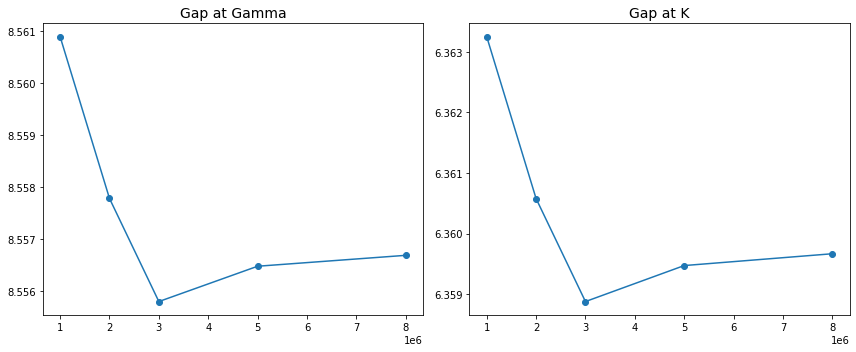

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(RandQpts,gap_G)
axes[0].scatter(RandQpts,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(RandQpts, gap_K)
axes[1].scatter(RandQpts,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We also show the values of the valence and conduction bands

In [21]:
val_G = [r.data['hf']['Ehf'][0] for r in results_G]
cond_G = [r.data['hf']['Ehf'][1] for r in results_G]

val_K = [r.data['hf']['Ehf'][0] for r in results_K]
cond_K = [r.data['hf']['Ehf'][1] for r in results_K]

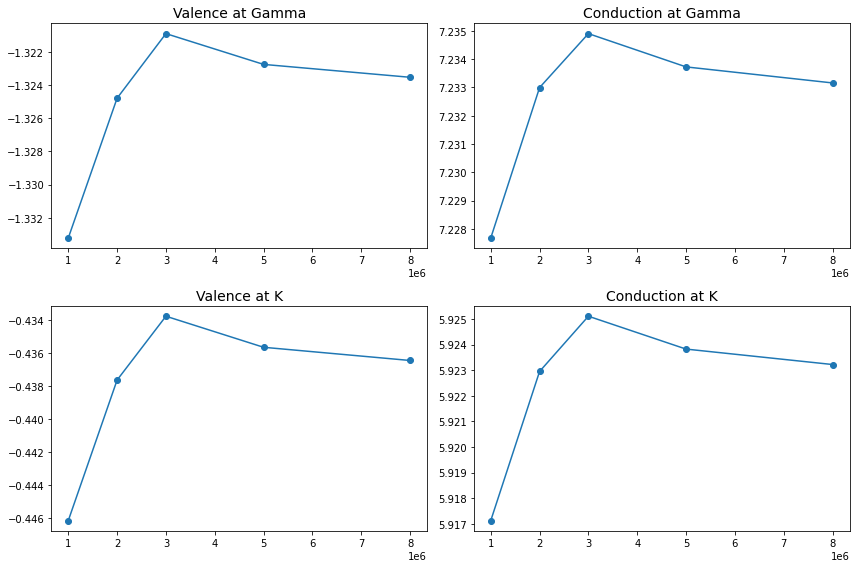

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0,0].plot(RandQpts,val_G)
axes[0,0].scatter(RandQpts,val_G)
axes[0,0].set_title('Valence at Gamma',size=14)
axes[0,1].plot(RandQpts, cond_G)
axes[0,1].scatter(RandQpts,cond_G)
axes[0,1].set_title('Conduction at Gamma',size=14)

axes[1,0].plot(RandQpts,val_K)
axes[1,0].scatter(RandQpts,val_K)
axes[1,0].set_title('Valence at K',size=14)
axes[1,1].plot(RandQpts, cond_K)
axes[1,1].scatter(RandQpts,cond_K)
axes[1,1].set_title('Conduction at K',size=14)

fig.tight_layout()

Also for the RandQpts parameter we observe that the gap is converged at the level of 1eV at 1e6 while
the convergence of the individual states requires higher values. 

On the basis of this analysis we choose the converged parameters for the RIM_W and Coulomb cutoff as
* RandGVec = 100
* RandGvecW = 100
* RandQPpts = 5000000

The RandGvecW cannot be tested at the level of HF, we choose this value using the HF analysis for the RandGvec as guideline.

## HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 18x18x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

In [23]:
source_dir = 'DFT_analysis/kpoints_18-nbnds_250.save'
run_dir = 'GW_analysis/kpoints_18-nbnds_250'

Tools.build_SAVE(source_dir,run_dir)

SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.


We the define the input variables commmon to all the runs

In [28]:
start_band,stop_band = 26,27 # bands range for the computation of the HF corrections
Gamma_index, K_index = 1, 37
RandGvec = 100
RandGvecW = 100
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
inp.set_extendOut()

inp.set_bandRange(start_band,stop_band)
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [Randqpts,'']

inp

{'args': 'mpirun -np 1 yambo -r -x -V all',
 'folder': 'GW_analysis/kpoints_18-nbnds_250',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC', 'ExtendOut'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [26.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [262858.0, 'Kb'],
  'FFTGvecs': [18201.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [100, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [116627.0, 'RL'],
  'VXCRLvcs': [116627.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 37, 26, 27], ''],
  'QPerange': [[1, 37, 0.0, '-1.000000'], ''],
  'RandGvecW': [100, 'RL']}}

We perform a convergence run on the EXXRLvcs parameter

In [51]:
study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.] # Ha

inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']

# append runs for the Gamma point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(Gamma_index,Gamma_index)
    inp['variables']['EXXRLvcs'] = [exxrlvcs,EXXRLVcs_units]
    inp['variables']['VXCRLvcs'] = [exxrlvcs,EXXRLVcs_units]
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

# append runs for the K point
for exxrlvcs in EXXRLvcs:
    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp['variables']['EXXRLvcs'] = [exxrlvcs,EXXRLVcs_units]
    inp['variables']['VXCRLvcs'] = [exxrlvcs,EXXRLVcs_units]
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 2 parallel tasks


In [52]:
#study.runs[0]

In [53]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7]] 

Run the task [0, 1] 
Skip the run of hf-G-exxrlvcs_20.0
run command: mpirun -np 16 yambo -F hf-G-exxrlvcs_10.0.in -J hf-G-exxrlvcs_10.0 -C hf-G-exxrlvcs_10.0
slurm submit:  cd GW_analysis/kpoints_18-nbnds_250 ; sbatch job_hf-G-exxrlvcs_10.0.sh
computation hf-G-exxrlvcs_10.0 is running...
computation hf-G-exxrlvcs_10.0 ended
Run performed in 01m-25s
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-exxrlvcs_30.0
Skip the run of hf-G-exxrlvcs_40.0
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of hf-K-exxrlvcs_20.0
run command: mpirun -np 16 yambo -F hf-K-exxrlvcs_10.0.in -J hf-K-exxrlvcs_10.0 -C hf-K-exxrlvcs_10.0
slurm submit:  cd GW_analysis/kpoints_18-nbnds_250 ; sbatch job_hf-K-exxrlvcs_10.0.sh
computation hf-K-exxrlvcs_10.0 is running...
computation hf-K-exxrlvcs_10.0 ended
Run performed in 01m-26s
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of

We plot the values of the gap (both at $\Gamma$ and at $K$) point

In [54]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G = [r.data.get_gap(k_full=Gamma_index,band_full=start_band,verbose=False) for r in results_G]
gap_K = [r.data.get_gap(k_full=K_index,band_full=start_band,verbose=False) for r in results_K]
gap_G,gap_K

([8.524924, 8.554708999999999, 8.556481, 8.556472],
 [6.418058, 6.361589, 6.359523, 6.359471])

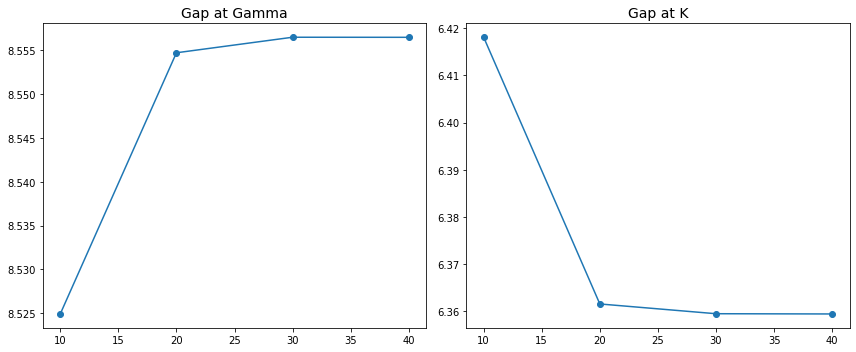

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap_G)
axes[0].scatter(EXXRLvcs,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 30 Ha

## HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [56]:
RandQpts = 5000000
RandGvec = 100 
RandGvecW = 100

start_band,stop_band = 26,27 # bands range for the computation of the HF corrections
Gamma_index = {18:1,30:1,42:1}
K_index = {18:37,30:91,42:169}

EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'

In [59]:
kpoints = [18,30,42]

In [60]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_250.save'%k
    run_dir = 'GW_analysis/kpoints_%s-nbnds_250'%k
    Tools.build_SAVE(source_dir,run_dir)
    
    inp = I.YamboInput(args='mpirun -np 1 yambo -r -x -V all',folder=run_dir)
    inp.set_extendOut()
    inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp.set_bandRange(start_band,stop_band)
    inp['variables']['CUTGeo'] = 'slab z'
    inp['variables']['RandGvec'] = [RandGvec,'RL']
    inp['variables']['RandGvecW'] = [RandGvecW,'RL']
    inp['variables']['RandQpts'] = [RandQpts,'']
    inp['variables']['SE_CPU'] = '1.1.16' # for 1 node on ismhpc
    inp['variables']['SE_ROLEs'] = 'q.qp.b'
    
    # append run at G
    idd = 'hf-G-slab_z-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)
    # append run at K
    idd = 'hf-K-slab_z-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=idd)

Initialize a Dataset with 2 parallel tasks
SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.
SAVE folder already present in GW_analysis/kpoints_30-nbnds_250. No operations performed.
SAVE folder already present in GW_analysis/kpoints_42-nbnds_250. No operations performed.


In [68]:
#study.runs[4]

In [69]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
delete job_out script: GW_analysis/kpoints_18-nbnds_250/job_hf-K-slab_z-kpoints_18.out
delete folder: GW_analysis/kpoints_18-nbnds_250/hf-K-slab_z-kpoints_18
run command: mpirun -np 16 yambo -F hf-K-slab_z-kpoints_18.in -J hf-K-slab_z-kpoints_18 -C hf-K-slab_z-kpoints_18
slurm submit:  cd GW_analysis/kpoints_18-nbnds_250 ; sbatch job_hf-K-slab_z-kpoints_18.sh
delete job_out script: GW_analysis/kpoints_18-nbnds_250/job_hf-G-slab_z-kpoints_18.out
computation hf-K-slab_z-kpoints_18 is running...
delete folder: GW_analysis/kpoints_18-nbnds_250/hf-G-slab_z-kpoints_18
run command: mpirun -np 16 yambo -F hf-G-slab_z-kpoints_18.in -J hf-G-slab_z-kpoints_18 -C hf-G-slab_z-kpoints_18
slurm submit:  cd GW_analysis/kpoints_18-nbnds_250 ; sbatch job_hf-G-slab_z-kpoints_18.sh
computation hf-G-slab_z-kpoints_18 is running...
computation hf-G-slab_z-kpoints_18 ended
Run performed in 01m-1

In [70]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
gap_G, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
gap_G, gap_K

([8.556481, 8.5675, 8.571136000000001],
 [6.35952, 6.3721820000000005, 6.377229])

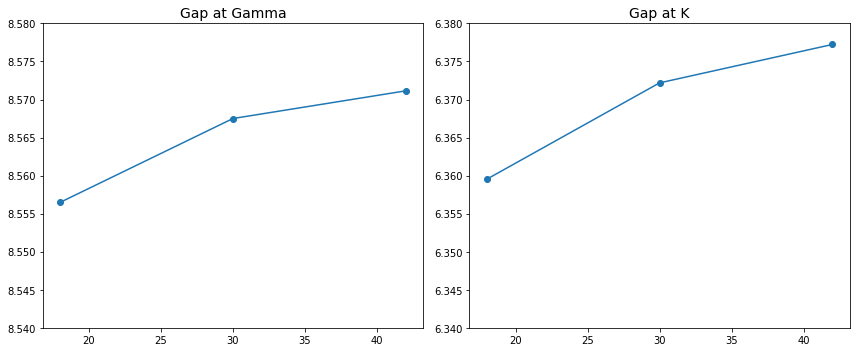

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[0].set_ylim(8.54,8.58)
axes[1].set_ylim(6.34,6.38)
fig.tight_layout()

With the 42x42x1 sampling the HF gap both at $\Gamma$ and at $K$ is converged at
the level of 5 meV.

## COHSEX Analysis

We study the convergence of the gap at $\Gamma$ and at $K$ using the cohsex run level. 

In [91]:
source_dir = 'DFT_analysis/kpoints_18-nbnds_250.save'
run_dir = 'GW_analysis/kpoints_18-nbnds_250'

Tools.build_SAVE(source_dir,run_dir)

SAVE folder already present in GW_analysis/kpoints_18-nbnds_250. No operations performed.


We the define the input variables commmon to all the runs

In [138]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 26,27
Gamma_index, K_index = 1, 37
RandGvec = 100
RandGvecW = 100
Randqpts = 5e6

EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 c -V all',folder=run_dir)
inp.set_extendOut()
inp.set_RIM_W()
inp.set_bandRange(start_band,stop_band)
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [Randqpts,'']
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
#inp['variables']['NGsBlkXs'] = [NGsBlkXs,NGsBlkXs_units]
#inp['variables']['BndsRnXs'] = [BndsRnXs,'']

inp['variables']['SE_CPU'] = '1.1.16' # for 1 nodes on ismhpc
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

#inp

16 1


In [133]:
NGsBlkXs = [2.,4.,6.] # Ha G size of the response function
NGsBlkXs_units = 'Ha'
BndsRnXs  = [1,100] # Bands in the response function

inp['variables']['BndsRnXs'] = [BndsRnXs,'']

In [134]:
study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxs in NGsBlkXs[0:1]:
    # append run at G
    idd = 'cohsex-G-eps_conv-ngsblkxs_%s-bndsrnxs_%s'%(ngsblkxs,BndsRnXs[1])
    #idd = 'test'
    inp['variables']['NGsBlkXs'] = [ngsblkxs,NGsBlkXs_units]
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb-em1s_cohsex-ngsblkxs_2.0-bndsrnxs_100'],reformat=False)
    # append run at K
    idd = 'cohsex-K-eps_conv-ngsblkxs_%s-bndsrnxs_%s'%(ngsblkxs,BndsRnXs[1])
    inp['variables']['NGsBlkXs'] = [ngsblkxs,NGsBlkXs_units]
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_K'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [135]:
#study.runs[0]

In [136]:
results = study.run(selection=[0])

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
delete job_out script: GW_analysis/kpoints_18-nbnds_250/job_test.out
delete folder: GW_analysis/kpoints_18-nbnds_250/test
run command: mpirun -np 16 yambo -F test.in -J "test,ndb_rim_cutoff,ndb_dipoles,ndb_hf_gamma,ndb-em1s_cohsex-ngsblkxs_2.0-bndsrnxs_100" -C test
slurm submit:  cd GW_analysis/kpoints_18-nbnds_250 ; sbatch job_test.sh
computation test is running...
computation test ended

        There are no o-* files.
        Maybe you have performed a ypp computation or wait_end_run and/or
        the dry_run option are active.
        Otherwise a possible error has occured during the computation
        
game_over string not found in report. Check the computation!
Task [0] ended 
 


In [ ]:
###################################################################################

## Plasmon pole analysis in function of the k-points sampling

We study the convergence of the gap at $\Gamma$ and at $K$ in function of the k-points sampling. We also investigate the
effects of the double-grid.

The double-grid has been analyzed with celldm3=6, this analysis has shown that the effect of the dg gives rise to
a worst evaluation of the gap at k=30 and is negligible at k=60. For these reasons the db is not implemented further
and the computations with celldm3=4 are performed without the dg

The common parameters in this analysis are

In [26]:
RandQpts = 5000000
RandGvec = 300 
RandGvecW = 100

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {30:1,60:1,81:1}
K_index = {30:91,60:331,81:588}
#EXXRLvcs = 40000 # RL # cutoff used with celldm3=6, corresponds to 50 Ha
#EXXRLVcs_units = 'RL'
EXXRLvcs = 50. # Ha # cutoff used with celldm3=4
EXXRLVcs_units = 'Ha'

#NGsBlkXs = 600 # RL G size of the response function used in the computation with celldm3 = 6, corresponds to 3.7 Ha
#NGsBlkXs_units = 'RL'
NGsBlkXs = 3.7 # Ha G size of the response function used in the computation with celldm3 = 4
NGsBlkXs_units = 'Ha'

BndsRnXs  = [1,300] # Bands in the response function
GbndRnge = [1,700]  # Bands in the Sigma_c

Note that for the response function we use _minimal_ values, a further convergence on these parameters will
be performed later.

We build the double grid ndb using the ypp -m option and we link the "../kpoints_81-nbnds_700" path

In [4]:
run_dir = 'GW_HF_analysis/kpoints_30-nbnds_700'
#run_dir = 'GW_HF_analysis/kpoints_60-nbnds_700'
inp = I.YamboInput(args='mpirun -np 1 ypp -m',folder=run_dir)
inp['variables']['FineGd_DB1_paths'] = ['../kpoints_81-nbnds_700','']
inp.write(run_dir,'ypp_dg.in')

Than we execute ypp with this input file and we move ndb.Double_Grid database built in the SAVE into a specific
folder so that it can be used only when needed.

In [27]:
kpoints = [30,60,81]

In [28]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    #source_dir = 'DFT_analysis/kpoints_%s-nbnds_700.save'%k
    #run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700'%k
    source_dir = 'DFT_analysis-vac_4/kpoints_%s-nbnds_700.save'%k
    run_dir = 'GW_HF_analysis/kpoints_%s-nbnds_700-vac_4'%k
    #Tools.build_SAVE(source_dir,run_dir,command='mpirun -np 1 p2y')
    
    inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut() 
    inp['arguments'].append('RIM_W') # activate the RIM_W 
    inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
    inp['variables']['NGsBlkXp'] = [NGsBlkXs,NGsBlkXs_units]
    inp['variables']['BndsRnXp'] = [BndsRnXs,'']
    inp['variables']['GbndRnge'] = [GbndRnge,'']
    inp.set_bandRange(start_band,stop_band)
    
    inp['variables']['CUTGeo'] = 'slab z'
    inp['variables']['RandGvec'] = [RandGvec,'RL']
    inp['variables']['RandGvecW'] = [RandGvecW,'RL']
    inp['variables']['RandQpts'] = [RandQpts,'']
    
    inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
    #inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
    inp['variables']['SE_ROLEs'] = 'q.qp.b'
    inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
    inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
    inp['variables']['DIP_ROLEs'] = 'k.c.v'
    inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

    # append run at G
    idd = 'pp-G-slab_z-kpoints_%s'%k
    inp.set_kRange(Gamma_index[k],Gamma_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%NGsBlkXs])
    # append run at K
    idd = 'pp-K-slab_z-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_k','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%NGsBlkXs])
    
    if k == -1: # != 81:
        #append run at G with double grid
        idd = 'pp-G_double_grid-slab_z-kpoints_%s'%k
        inp.set_kRange(Gamma_index[k],Gamma_index[k])
        study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_double_grid',
                              'ndb_pp_dg-ngsblkxs_600-bndsrnxs_300'])
        #append run at K with double grid
        idd = 'pp-K_double_grid-slab_z-kpoints_%s'%k
        inp.set_kRange(K_index[k],K_index[k])
        study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_k','ndb_double_grid',
                              'ndb_pp_dg-ngsblkxs_600-bndsrnxs_300'])

16 2
Initialize a Dataset with 1 parallel tasks


In [25]:
#study.runs[0]

In [29]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0], [1], [2], [3], [4], [5]] 

Run the task [0] 
Skip the run of pp-G-slab_z-kpoints_30
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-slab_z-kpoints_30
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-slab_z-kpoints_60
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-slab_z-kpoints_60
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-slab_z-kpoints_81
Task [4] ended 
 
Run the task [5] 
Skip the run of pp-K-slab_z-kpoints_81
Task [5] ended 
 


In [30]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
#results_G_dg, results_K_dg = study.fetch_results(id='-G_double_grid-'),study.fetch_results(id='-K_double_grid-')

gap_G, gap_K,gap_G_dg, gap_K_dg = [],[],[],[]
for ind,k in enumerate(kpoints):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))
#for ind,k in enumerate(kpoints[:-1]):
#    gap_G_dg.append(results_G_dg[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
#    gap_K_dg.append(results_K_dg[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))

In [31]:
gap_G,gap_G_dg,gap_K,gap_K_dg

([0.925404, 0.536946, 0.450689],
 [],
 [0.29137700000000005, 0.135652, 0.10341800000000001],
 [])

In [10]:
# norimw
gap_G,gap_G_dg,gap_K,gap_K_dg

([0.5815229999999999], [], [0.23282800000000003], [])

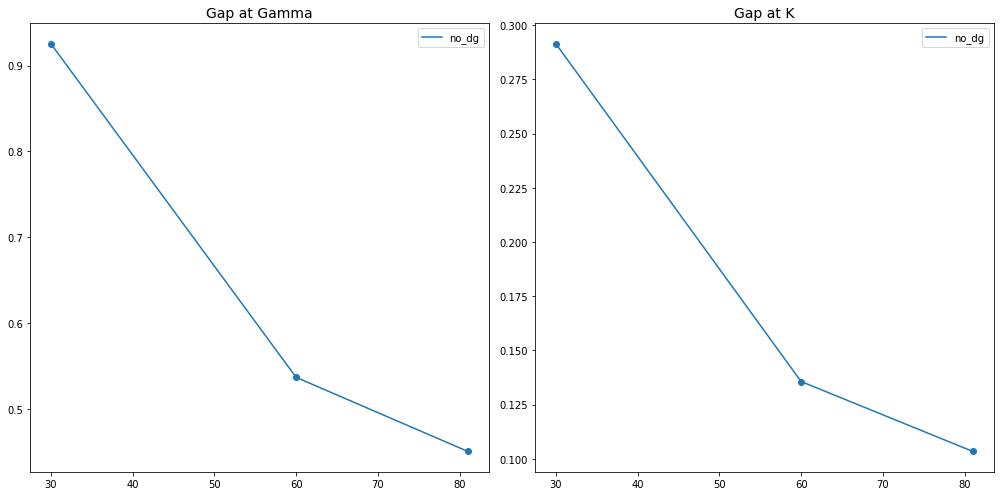

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(kpoints,gap_G,label='no_dg')
axes[0].scatter(kpoints,gap_G)
#axes[0].plot(kpoints[:-1],gap_G_dg,label='dg')
#axes[0].scatter(kpoints[:-1],gap_G_dg)
axes[0].legend()
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(kpoints, gap_K,label='no_dg')
axes[1].scatter(kpoints,gap_K)
#axes[1].plot(kpoints[:-1],gap_K_dg,label='dg')
#axes[1].scatter(kpoints[:-1],gap_K_dg)
axes[1].legend()
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

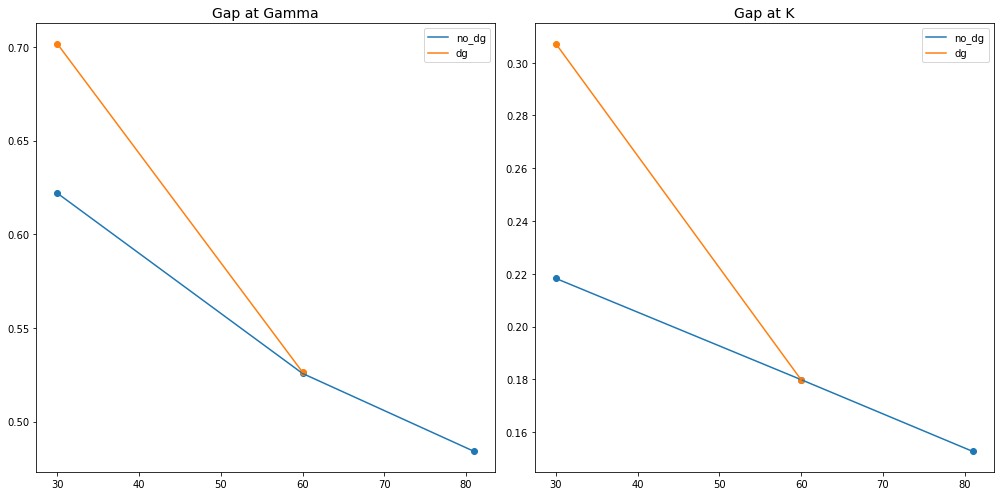

In [22]:
# results for celldm3=6

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(kpoints,gap_G,label='no_dg')
axes[0].scatter(kpoints,gap_G)
axes[0].plot(kpoints[:-1],gap_G_dg,label='dg')
axes[0].scatter(kpoints[:-1],gap_G_dg)
axes[0].legend()
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(kpoints, gap_K,label='no_dg')
axes[1].scatter(kpoints,gap_K)
axes[1].plot(kpoints[:-1],gap_K_dg,label='dg')
axes[1].scatter(kpoints[:-1],gap_K_dg)
axes[1].legend()
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We analyze the convergence of the correlation part of the self energy

In [41]:
sc_gamma_val = np.array([r.data['qp']['sce0'][0] for r in results_G])
sc_gamma_con = np.array([r.data['qp']['sce0'][1] for r in results_G])

sc_k_val = np.array([r.data['qp']['sce0'][0] for r in results_K])
sc_k_con = np.array([r.data['qp']['sce0'][1] for r in results_K])

In [43]:
sc_gamma_val,sc_gamma_con,sc_k_val,sc_k_con

(array([0.694234, 0.753359, 0.765355]),
 array([-4.037687, -4.130351, -4.151757]),
 array([-1.282558, -1.3231  , -1.335407]),
 array([-1.689573, -1.64963 , -1.637463]))

In [46]:
sc_gamma_gap = sc_gamma_con-sc_gamma_val
sc_k_gap = sc_k_con-sc_k_val
sc_gamma_gap,sc_k_gap

(array([-4.731921, -4.88371 , -4.917112]),
 array([-0.407015, -0.32653 , -0.302056]))

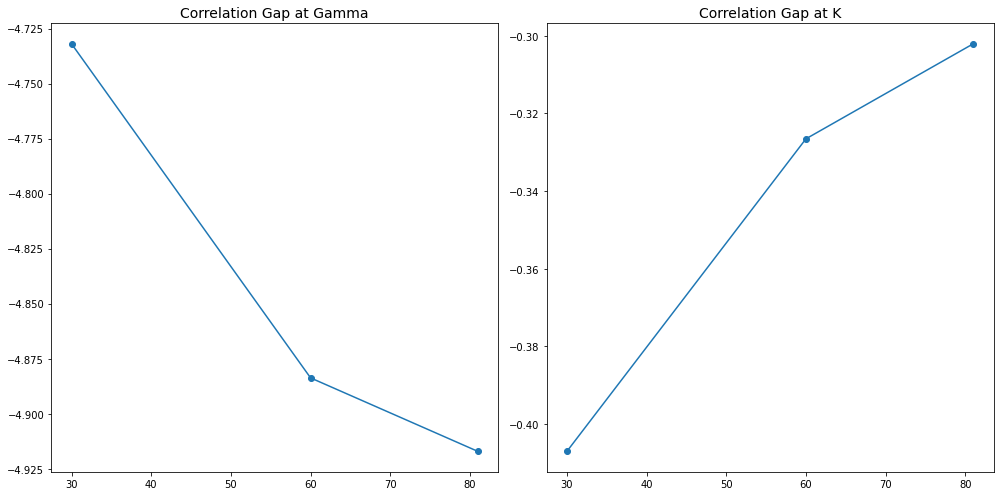

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(kpoints,sc_gamma_gap)
axes[0].scatter(kpoints,sc_gamma_gap)
axes[0].set_title('Correlation Gap at Gamma',size=14)
axes[1].plot(kpoints,sc_k_gap)
axes[1].scatter(kpoints,sc_k_gap)
axes[1].set_title('Correlation Gap at K',size=14)
fig.tight_layout()

These plots evidence that also the correlation part of the gap convergen slowly w.r.t the kpoints sampling.

## Convergence analysis of the screening at the PP level 

We perform a convergence analysis of the ndb.pp at the plasmon pole level in terms of the NGsBlkXs and
of the BndsRnXs parameters. This analysis is performed on the 30x30x1 kpoints sampling. We use the gap
at $\Gamma$ and at $K$ as convergence test observables. 

In [4]:
RandQpts = 5000000
RandGvec = 300 
RandGvecW = 100

start_band,stop_band = 28,29 # bands range for the computation of the HF corrections
Gamma_index = {30:1,60:1,81:1}
K_index = {30:91,60:331,81:588}
EXXRLvcs = 50. # Ha # cutoff used with celldm3=4
EXXRLVcs_units = 'Ha'

GbndRnge = [1,700]  # Bands in the Sigma_c

run_dir = 'GW_HF_analysis/kpoints_30-nbnds_700-vac_4'
k = 30

First we run over the NGsBlkXs parameter

In [5]:
BndsRnXs  = [1,300] # Bands in the response function

NGsBlkXs_vals = [3.7,5,6,10]
NGsBlkXs_units = 'Ha'

In [6]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)
    
inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut() 
inp['arguments'].append('RIM_W') # activate the RIM_W 
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['BndsRnXp'] = [BndsRnXs,'']
inp['variables']['GbndRnge'] = [GbndRnge,'']
inp.set_bandRange(start_band,stop_band)
    
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [RandQpts,'']
    
inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
#inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

for ngsblkxs in NGsBlkXs_vals:
    # append run at G
    idd = 'pp-G-eps_conv-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs
    inp['variables']['NGsBlkXp'] = [ngsblkxs,NGsBlkXs_units]
    inp.set_kRange(Gamma_index[30],Gamma_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs])
    # append run at K
    idd = 'pp-K-eps_conv-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs
    inp['variables']['NGsBlkXp'] = [ngsblkxs,NGsBlkXs_units]
    inp.set_kRange(K_index[30],K_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_K','ndb_pp-ngsblkxs_%s-bndsrnxs_300'%ngsblkxs])
    

16 2
Initialize a Dataset with 1 parallel tasks


In [11]:
#study.runs[7]

In [7]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0], [1], [2], [3], [4], [5], [6], [7]] 

Run the task [0] 
Skip the run of pp-G-eps_conv-ngsblkxs_3.7-bndsrnxs_300
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-eps_conv-ngsblkxs_3.7-bndsrnxs_300
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-eps_conv-ngsblkxs_5-bndsrnxs_300
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-eps_conv-ngsblkxs_5-bndsrnxs_300
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-eps_conv-ngsblkxs_6-bndsrnxs_300
Task [4] ended 
 
Run the task [5] 
Skip the run of pp-K-eps_conv-ngsblkxs_6-bndsrnxs_300
Task [5] ended 
 
Run the task [6] 
Skip the run of pp-G-eps_conv-ngsblkxs_10-bndsrnxs_300
Task [6] ended 
 
Run the task [7] 
run command: mpirun -np 32 yambo -F pp-K-eps_conv-ngsblkxs_10-bndsrnxs_300.in -J "pp-K-eps_conv-ngsblkxs_10-bndsrnxs_300,ndb_rim_cutoff,ndb_dipoles,ndb_hf_K,ndb_pp-ngsblkxs_10-bndsrnxs_300" -C pp-K-eps_conv-ngsblkxs_10-bndsrnxs_300

In [8]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')
#results_G_dg, results_K_dg = study.fetch_results(id='-G_double_grid-'),study.fetch_results(id='-K_double_grid-')

gap_G, gap_K = [],[]
for ind in range(len(NGsBlkXs_vals)):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))


In [9]:
gap_G,gap_K

([0.925404, 0.9250910000000001, 0.9245510000000001, 0.925053],
 [0.29137700000000005, 0.29316500000000006, 0.293586, 0.293862])

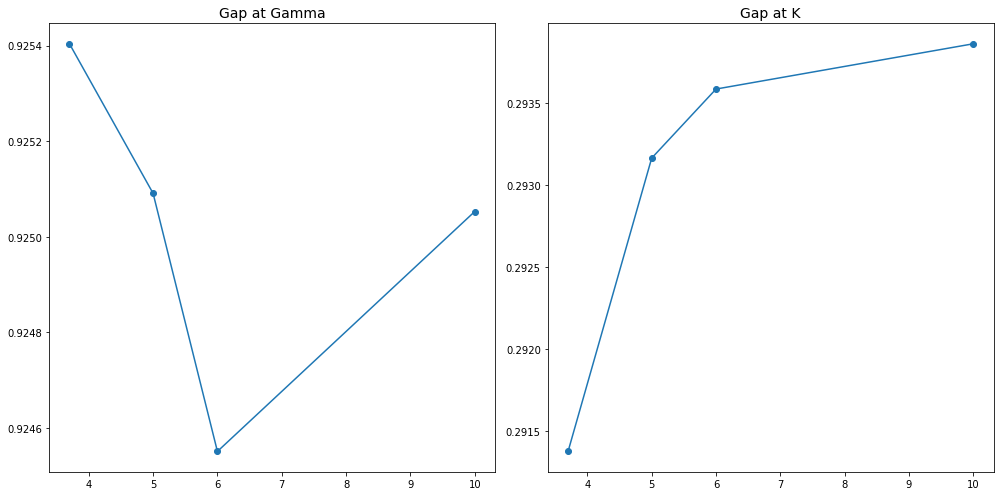

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(NGsBlkXs_vals,gap_G)
axes[0].scatter(NGsBlkXs_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(NGsBlkXs_vals, gap_K)
axes[1].scatter(NGsBlkXs_vals,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we choose NGsBlkXs = 5 Ha as converged value.

Then we run over BndsRnXs

In [19]:
NGsBlkXs = 5
NGsBlkXs_units = 'Ha'

BndsRnXs_vals  = [[1,300],[1,400],[1,500]] # Bands in the response function

In [20]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)
    
inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut() 
inp['arguments'].append('RIM_W') # activate the RIM_W 
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['NGsBlkXp'] = [NGsBlkXs,NGsBlkXs_units]
inp['variables']['GbndRnge'] = [GbndRnge,'']
inp.set_bandRange(start_band,stop_band)
    
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [RandQpts,'']
    
inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
#inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

for bndsrnxs in BndsRnXs_vals:
    # append run at G
    idd = 'pp-G-eps_conv-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]
    inp['variables']['BndsRnXp'] = [bndsrnxs,'']
    inp.set_kRange(Gamma_index[30],Gamma_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_pp-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]])
    # append run at K
    idd = 'pp-K-eps_conv-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]
    inp['variables']['BndsRnXp'] = [bndsrnxs,'']
    inp.set_kRange(K_index[30],K_index[30])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
                     jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_K','ndb_pp-ngsblkxs_5-bndsrnxs_%s'%bndsrnxs[1]])
    

16 2
Initialize a Dataset with 1 parallel tasks


In [22]:
#study.runs[5]

In [23]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0], [1], [2], [3], [4], [5]] 

Run the task [0] 
Skip the run of pp-G-eps_conv-ngsblkxs_5-bndsrnxs_300
Task [0] ended 
 
Run the task [1] 
Skip the run of pp-K-eps_conv-ngsblkxs_5-bndsrnxs_300
Task [1] ended 
 
Run the task [2] 
Skip the run of pp-G-eps_conv-ngsblkxs_5-bndsrnxs_400
Task [2] ended 
 
Run the task [3] 
Skip the run of pp-K-eps_conv-ngsblkxs_5-bndsrnxs_400
Task [3] ended 
 
Run the task [4] 
Skip the run of pp-G-eps_conv-ngsblkxs_5-bndsrnxs_500
Task [4] ended 
 
Run the task [5] 
Skip the run of pp-K-eps_conv-ngsblkxs_5-bndsrnxs_500
Task [5] ended 
 


In [24]:
results_G, results_K = study.fetch_results(id='-G-'),study.fetch_results(id='-K-')

gap_G, gap_K = [],[]
for ind in range(len(BndsRnXs_vals)):
    gap_G.append(results_G[ind].data.get_gap(k_full=Gamma_index[k],band_full=start_band,verbose=False))
    gap_K.append(results_K[ind].data.get_gap(k_full=K_index[k],band_full=start_band,verbose=False))


In [25]:
gap_G,gap_K

([0.9250910000000001, 0.9408850000000001, 0.950193],
 [0.29316500000000006, 0.315275, 0.329327])

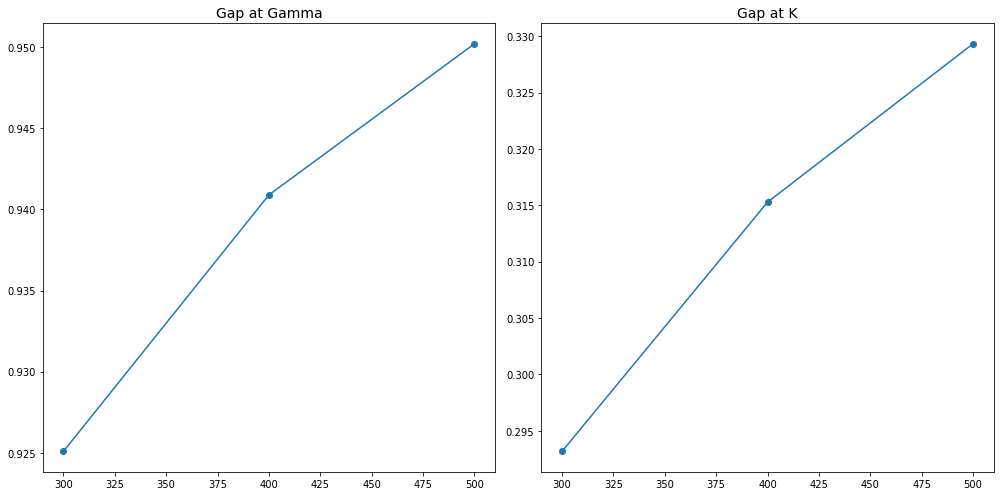

In [38]:
x_vals = [x[1] for x in BndsRnXs_vals]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].plot(x_vals,gap_G)
axes[0].scatter(x_vals,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

These plots evidence that 500 bands are not sufficient to obtain a converged value of the gap, so all the 700 bands
will be used to build the screening.

## Analysis of the band structure at the PP level

We use the results of the convergence analysis to build the QP correction at the PP level in the whole BZ.

The converged parameters read

In [4]:
RandQpts = 5000000
RandGvec = 300 
RandGvecW = 100

Gamma_index = {30:1,60:1,81:1}
K_index = {30:91,60:331,81:588}
EXXRLvcs = 50. # Ha # cutoff used with celldm3=4
EXXRLVcs_units = 'Ha'
NGsBlkXs = 5
NGsBlkXs_units = 'Ha'
BndsRnXs  = [1,700] # Bands in the response function
GbndRnge = [1,700]  # Bands in the Sigma_c

run_dir = 'GW_HF_analysis/kpoints_81-nbnds_700-vac_4'
k = 81

First we build the ndb.pp database. To do so we perform a pp computation at $\Gamma$ 

In [11]:
start_band,stop_band = 28,29 # bands range for the computation of the HF corrections

In [12]:
ntasks_c = 32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)
    
inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut() 
inp['arguments'].append('RIM_W') # activate the RIM_W 
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['NGsBlkXp'] = [NGsBlkXs,NGsBlkXs_units]
inp['variables']['GbndRnge'] = [GbndRnge,'']
inp.set_bandRange(start_band,stop_band)
    
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [RandQpts,'']
    
#inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

# append run at G
idd = 'pp-G-eps_conv-ngsblkxs_5-bndsrnxs_%s'%BndsRnXs[1]
inp['variables']['BndsRnXp'] = [BndsRnXs,'']
inp.set_kRange(Gamma_index[k],Gamma_index[k])
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
        jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_gamma','ndb_pp-ngsblkxs_5-bndsrnxs_%s'%BndsRnXs[1]])

32 2
Initialize a Dataset with 1 parallel tasks


In [14]:
#study.runs[0]

In [15]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of pp-G-eps_conv-ngsblkxs_5-bndsrnxs_700
Task [0] ended 
 


In [17]:
results[0].data.get_gap(k_full=Gamma_index[k],band_full=start_band)

0.40873799999999993

Once that we have all the database we perform the PP computation in the whole BZ using an extended band range

In [8]:
start_kp,stop_kp = 1,588
start_band,stop_band = 25,32 # bands range for the computation of the GW corrections

ntasks_c = 16 #32
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

study = D.Dataset(num_tasks=1,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)
    
inp = I.YamboInput(args='mpirun -np 1 yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut() 
inp['arguments'].append('RIM_W') # activate the RIM_W 
inp['variables']['EXXRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['VXCRLvcs'] = [EXXRLvcs,EXXRLVcs_units]
inp['variables']['NGsBlkXp'] = [NGsBlkXs,NGsBlkXs_units]
inp['variables']['BndsRnXp'] = [BndsRnXs,'']
inp['variables']['GbndRnge'] = [GbndRnge,'']
inp.set_bandRange(start_band,stop_band)
inp.set_kRange(start_kp,stop_kp)
    
inp['variables']['CUTGeo'] = 'slab z'
inp['variables']['RandGvec'] = [RandGvec,'RL']
inp['variables']['RandGvecW'] = [RandGvecW,'RL']
inp['variables']['RandQpts'] = [RandQpts,'']
    
inp['variables']['SE_CPU'] = '2.1.16' # for 2 nodes on ismhpc or 8 nodes on 100
#inp['variables']['SE_CPU'] = '2.2.16' # for 16 nodes on m100
#inp['variables']['SE_CPU'] = '2.4.16' # for 32 nodes on m100
inp['variables']['SE_ROLEs'] = 'q.qp.b'
inp['variables']['X_and_IO_ROLEs'] = 'q.g.k.c.v'
inp['variables']['X_and_IO_CPU'] = '1.1.1.%s.%s'%(ntasks_c,ntasks_v)
inp['variables']['DIP_ROLEs'] = 'k.c.v'
inp['variables']['DIP_CPU'] = '1.%s.%s'%(ntasks_c,ntasks_v)

idd = 'pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700'
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,'ndb_rim_cutoff','ndb_dipoles','ndb_hf_allBz','ndb_pp-ngsblkxs_5-bndsrnxs_700'])

16 2
Initialize a Dataset with 1 parallel tasks


In [9]:
#study.runs[0]

In [10]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
Skip the run of pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700
Task [0] ended 
 


In [11]:
results[0].data.get_gap(k_full=Gamma_index[k],band_full=28)

0.4087449999999999

In [12]:
results[0].data.get_gap(k_full=K_index[k],band_full=28)

0.11436100000000005

## Ypp analysis

We use the previous results to compute the GW correction of the band structure along a high symmetry path.

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 16
cpus_per_task=2
omp_num_threads=2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #fastnodes
                memory='124000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,executable='ypp',activate_BeeOND=True) #,clean_restart=False,skip=False)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 16,
 'cpus_per_task': 2,
 'omp_num_threads': 2,
 'gpus_per_node': None,
 'memory': '124000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'ypp',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [4]:
run_dir = 'GW_HF_analysis/kpoints_81-nbnds_700-vac_4/'
ndbQP = 'pp-allBZ-ngsblkxs_5-bndsrnxs_700-gbndrnge_700/ndb.QP'

Initialize a Dataset with 2 parallel tasks


In [42]:
# with BANDS_kpts

band_range = [25,32]
bands_step = 50

# in crystal coordinates
G = [0.,0.,0.]
Kp = [1./3.,1./3.,0.]
Mp = [0.,0.5,0.]
high_sym = {'G':G,'K':Kp,'M':Mp} # useful to label the high-sym point on the path
path = [G,Mp,Kp,G]

study = D.Dataset(run_dir=run_dir,num_tasks=2,verbose=True,skip=False)

inp = I.YamboInput(args='mpirun -np 1 ypp -s b -V qp',folder=run_dir,filename='ypp.in')
inp['variables']['BANDS_bands'] = [band_range,'']
inp['variables']['BANDS_steps'] = [bands_step,'']
inp['variables']['BANDS_kpts'] = [path,'']
inp['variables']['cooIn'] = 'rlu'
inp['variables']['cooOut'] = 'rlu'

idd = 'ypp_bands_dft_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [20,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [20,'']
study.append_run(id=idd,input=inp,runner=code) #,skip=False

idd = 'ypp_bands_gw_boltz'
inp['variables']['INTERP_mode'] = 'BOLTZ'
inp['variables']['INTERP_Shell_Fac'] = [10,'']
inp['variables']['GfnQP_DbGd_INTERP_mode'] = 'BOLTZ'
inp['variables']['GfnQP_INTERP_shells'] = [10,'']
inp['variables']['GfnQPdb']= 'E < %s'%ndbQP
study.append_run(id=idd,input=inp,runner=code,skip=False) #,skip=False

Initialize a Dataset with 2 parallel tasks


In [43]:
#study.runs[1]

In [44]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0, 1]] 

Run the task [0, 1] 
delete job_out script: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/job_ypp_bands_gw_boltz.out
delete folder: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/ypp_bands_gw_boltz
run command: mpirun -np 16 ypp -F ypp_bands_gw_boltz.in -J ypp_bands_gw_boltz -C ypp_bands_gw_boltz
slurm submit:  cd GW_HF_analysis/kpoints_81-nbnds_700-vac_4/ ; sbatch job_ypp_bands_gw_boltz.sh
computation ypp_bands_gw_boltz is running...
delete job_out script: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/job_ypp_bands_dft_boltz.out
delete folder: GW_HF_analysis/kpoints_81-nbnds_700-vac_4/ypp_bands_dft_boltz
run command: mpirun -np 16 ypp -F ypp_bands_dft_boltz.in -J ypp_bands_dft_boltz -C ypp_bands_dft_boltz
slurm submit:  cd GW_HF_analysis/kpoints_81-nbnds_700-vac_4/ ; sbatch job_ypp_bands_dft_boltz.sh
computation ypp_bands_dft_boltz is running...
computation ypp_bands_gw_boltz ended
Run performed in 46s
computation ypp_bands_dft_bolt

In [48]:
bands_gw = U.BandStructure.from_Ypp(results[1],high_sym,suffix='bands_interpolated')
bands_dft = U.BandStructure.from_Ypp(results[0],high_sym,suffix='bands_interpolated')

Text(0.5, 1.0, 'Germanene GW bands')

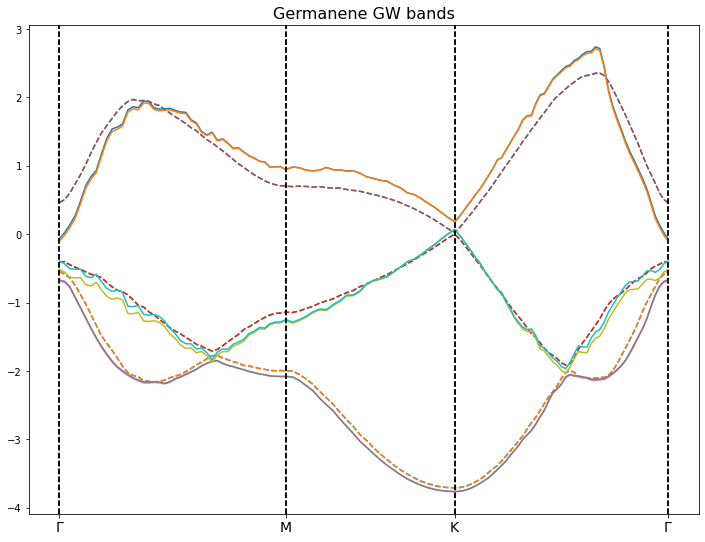

In [49]:
fig, ax = plt.subplots(figsize=(12, 9))
bands_dft.plot(plt,selection=[0,1,2,3,4,5],linestyle='--',label='dft')
bands_gw.plot(plt,selection=[0,1,2,3,4,5],linestyle='-',label='gw')
#plt.ylim(-1,1)
plt.title('Germanene GW bands',size=16)

Text(0.5, 1.0, 'Valence and conduction bands')

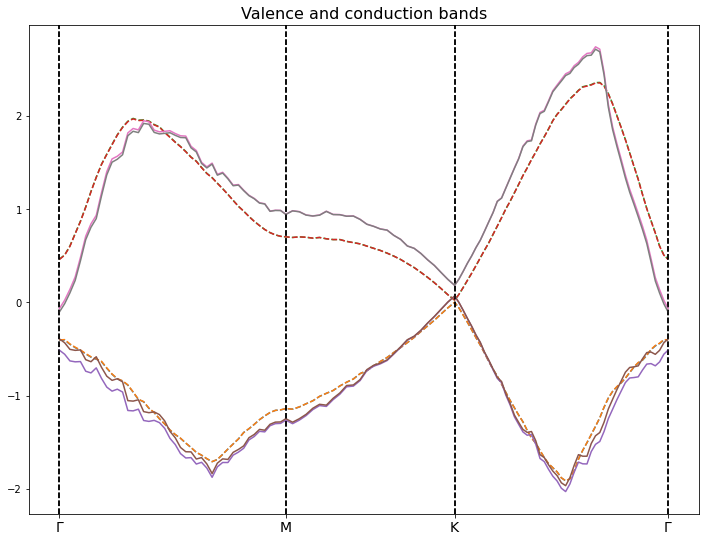

In [70]:
fig, ax = plt.subplots(figsize=(12, 9))
bands_dft.plot(plt,selection=[2,3,4,5],linestyle='--',)
bands_gw.plot(plt,selection=[2,3,4,5],linestyle='-')
#plt.ylim(-1,1)
plt.title('Valence and conduction bands',size=16)

In [57]:
bands_gw.get_high_sym_positions()

(['$\\Gamma$', '$\\Gamma$', 'K', 'M'],
 [0.0, 1.3440818224605495, 0.8726778140855642, 0.5])

In [77]:
ind_K = np.where(bands_gw.get_path()==bands_gw.get_high_sym_positions()[1][2])[0][0]
ind_K

68

In [78]:
bands_gw.bands[4][ind_K]-bands_gw.bands[3][ind_K],bands_dft.bands[4][ind_K]-bands_dft.bands[3][ind_K]

(0.11436099540000001, 0.0239409440455766)

In [79]:
bands_gw.bands[4][0]-bands_gw.bands[3][0],bands_dft.bands[4][0]-bands_dft.bands[3][0]

(0.3247290478, 0.866149813)